## Step 1: Problem formulation

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from ema_workbench import (Model, CategoricalParameter, ScalarOutcome, IntegerParameter, RealParameter)
from ema_workbench import (Model, MultiprocessingEvaluator, SequentialEvaluator, Policy, Scenario)
from dike_model_function import DikeNetwork 

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation

ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(6)

def sum_over(*args):
    return sum(args)

In [2]:
# #geen idee; volgens mij niet nodig, maar stond in voorbeeld
# uncertainties = dike_model.uncertainties
# levers = dike_model.levers 
# outcomes = dike_model.outcomes

## Step 2: Searching for candidate solutions

In [3]:
from ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

with SequentialEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=3, policies=3)
    
experiments, outcomes = results

[MainProcess/INFO] performing 3 scenarios * 3 policies * 1 model(s) = 9 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 6 cases completed
[MainProcess/INFO] 7 cases completed
[MainProcess/INFO] 8 cases completed
[MainProcess/INFO] 9 cases completed
[MainProcess/INFO] experiments finished


In [23]:
#deze duurde 3,5 uur om te runnen bij Maarten; kan de results ook inladen via Excel
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
optimize_min = [0,0,0,0,0,0,1e8]
optimize_max = [2e9, 1 ,1e9,1,2e8,1e5,2e9]
optimize_epsilon = [1e6,1e-3,1e6,1e-3,1e6,1e3,1e7]

convergence_metrics = [HyperVolume(minimum=optimize_min, maximum=optimize_max),
                       EpsilonProgress()]

# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results1, convergence = evaluator.optimize(nfe=25000, searchover='levers', epsilons=optimize_epsilon, 
#                                               convergence=convergence_metrics)

# results1.to_excel('./export/resultsoptimize25000_results_1.xlsx')
# convergence.to_excel('./export/resultsoptimize25000_convergence_1.xlsx')

# result_statistics = pd.DataFrame()
# result_statistics['mean']=(np.mean(results1))
# result_statistics['std']=(np.std(results1))
# result_statistics['min']=(np.min(results1))
# result_statistics['max']=(np.max(results1))
# result_statistics.to_excel('./export/resultsoptimize25000_statistics_1.xlsx')

results1 = pd.read_excel('./export/resultsoptimize25000_results_1.xlsx', index_col=0, )
convergence = pd.read_excel('./export/resultsoptimize25000_convergence_1.xlsx', index_col=0, )
result_statistics = pd.read_excel('./export/resultsoptimize25000_statistics_1.xlsx', index_col=0, )

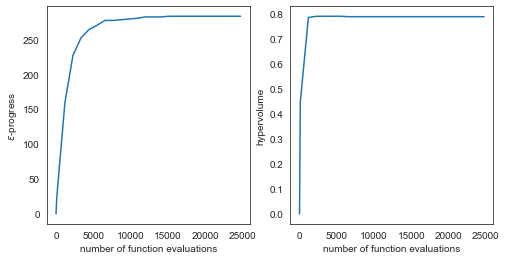

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

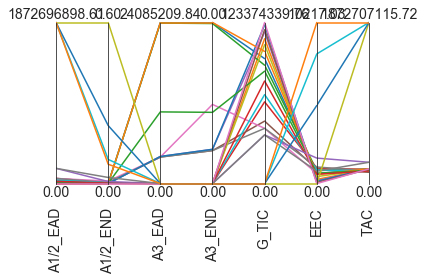

In [22]:
from ema_workbench.analysis import parcoords

data = results1.loc[:,['A1/2_EAD', 'A1/2_END', 'A3_EAD', 'A3_END', 'G_TIC', 'EEC', 'TAC']]
limits = parcoords.get_limits(data)
limits.loc[0, ['A1/2_EAD', 'A1/2_END', 'A3_EAD', 'A3_END', 'G_TIC', 'EEC', 'TAC']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

## Step 3: Re-evaluate candidate solutions under uncertainty
For this, I selected all policies where fewest deaths are fallen. But this could also be adapted to fewest 20% G_TIC or some other goals we have

In [24]:
results_new = results1
indexNames = results_new[ results_new['A1/2_END'] > np.percentile(results_new['A1/2_END'],50) ].index
results_new.drop(indexNames , inplace=True)
indexNames = results_new[ results_new['A3_END'] > np.percentile(results_new['A3_END'],50) ].index
results_new.drop(indexNames , inplace=True)

In [25]:
results_new

,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,A.4_DikeIncrease 0,A.5_DikeIncrease 0,A1/2_EAD,A1/2_END,A3_EAD,A3_END,G_TIC,EEC,TAC
1,0,0,0,0,0,2,4,2,1,0,7,9.073869e+06,0.000659,0.000000e+00,0.000000,1.109657e+08,262.710561,1.668717e+08
4,0,0,0,0,0,2,4,3,1,0,7,2.136422e+06,0.000158,4.050047e+06,0.000557,1.159899e+08,184.057027,1.690880e+08
8,0,0,0,0,0,3,4,1,1,0,6,1.585695e+07,0.000911,0.000000e+00,0.000000,1.063924e+08,442.668666,1.631153e+08
10,0,0,0,0,0,2,4,4,1,0,7,0.000000e+00,0.000000,4.050047e+06,0.000557,1.215058e+08,138.559055,1.724674e+08
13,0,0,1,0,0,2,4,0,0,0,6,2.658551e+07,0.001860,0.000000e+00,0.000000,7.854795e+07,591.457911,1.460022e+08
15,0,0,0,0,0,1,4,3,2,0,7,2.136422e+06,0.000379,0.000000e+00,0.000000,1.178585e+08,69.200304,1.669064e+08
16,0,0,0,0,0,0,4,4,2,0,7,0.000000e+00,0.000000,0.000000e+00,0.000000,1.233743e+08,0.000000,1.702858e+08


In [26]:
policies_values = results_new.drop(columns=['A1/2_EAD', 'A1/2_END', 'A3_EAD', 'A3_END', 'G_TIC', 'EEC', 'TAC'])
policies = []
for i, policy in policies_values.iterrows():
    policies.append(Policy(str(i), **policy.to_dict()))

In [27]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = perform_experiments(dike_model, scenarios=1000, policies=policies, evaluator=evaluator)
    experiments, outcomes = results
    
outcomes_df = pd.DataFrame(outcomes)
experiments.to_excel('./export/resultsexperiments_nodeaths1000_experiments.xlsx')
outcomes_df.to_excel('./export/resultsexperiments_nodeaths1000_outcomes.xlsx')

# experiments = pd.read_excel('./export/resultsexperiments_nodeaths1000_experiments.xlsx', index_col=0, )
# outcomes_df = pd.read_excel('./export/resultsexperiments_nodeaths1000_outcomes.xlsx', index_col=0, )

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 7 policies * 1 model(s) = 7000 experiments
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] 4200 cases completed
[MainProcess/INFO] 4900 cases completed
[MainProcess/INFO] 5600 cases completed
[MainProcess/INFO] 6300 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


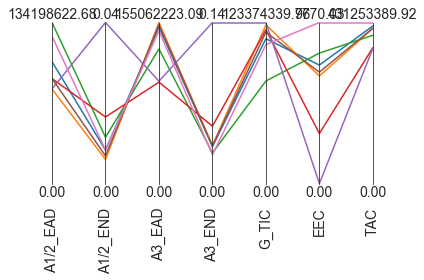

In [32]:
# Versie 4, code van maarten: Volgens mij is deze maximaal efficient :)
outcomes_mean = pd.DataFrame()
single_mean = {}

for policy in np.unique(experiments['policy']): #loop x times for x different unique policies
    logical = experiments['policy']==policy #series of true/false for policy iteration
    for key in outcomes_df.keys(): #loop x times for each key in outcomes
        single_mean[key] = np.mean(outcomes_df[key][logical])
    outcomes_mean = outcomes_mean.append(pd.DataFrame(single_mean, index = [policy]))

data = outcomes_mean
limits = parcoords.get_limits(data)
limits.loc[0, ['A1/2_EAD', 'A1/2_END', 'A3_EAD', 'A3_END', 'G_TIC', 'EEC', 'TAC']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

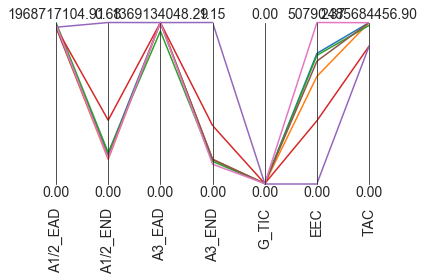

In [43]:
max_regret = pd.DataFrame()
single_regret = {}

for policy in np.unique(experiments['policy']): #loop x times for x different unique policies
    logical = experiments['policy']==policy #series of true/false for policy iteration
    for key in outcomes_df.keys(): #loop x times for each key in outcomes
        single_regret[key] = np.max(outcomes_df[key][logical])-np.min(outcomes_df[key][logical])
    max_regret = max_regret.append(pd.DataFrame(single_regret, index = [policy]))

data = max_regret
limits = parcoords.get_limits(data)
limits.loc[0, ['A1/2_EAD', 'A1/2_END', 'A3_EAD', 'A3_END', 'G_TIC', 'EEC', 'TAC']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

C:\Program Files (x86)\Anaconda\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


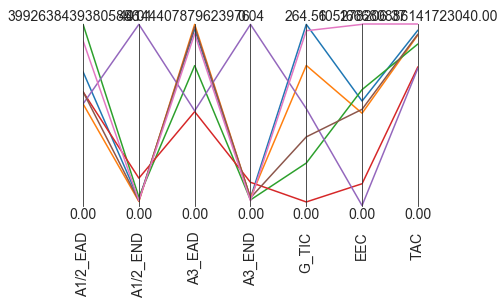

In [34]:
# Versie 4, code van maarten: Volgens mij is deze maximaal efficient :)
signal_to_noise = pd.DataFrame()
signal_single = {}

for policy in np.unique(experiments['policy']): #loop x times for x different unique policies
    logical = experiments['policy']==policy #series of true/false for policy iteration
    for key in outcomes_df.keys(): #loop x times for each key in outcomes
        signal_single[key] = np.mean(outcomes_df[key][logical])*np.std(outcomes_df[key][logical])
    signal_to_noise = signal_to_noise.append(pd.DataFrame(signal_single, index = [policy]))

data = signal_to_noise
limits = parcoords.get_limits(data)
limits.loc[0, ['A1/2_EAD', 'A1/2_END', 'A3_EAD', 'A3_END', 'G_TIC', 'EEC', 'TAC']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()